<a href="https://colab.research.google.com/github/hansufsm/FisicaIA/blob/main/esquadrao_fisicaia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎓 Projeto: Agentes IA para Estudantes Universitários
---

## 💡 Proposta: Sistema Colaborativo de Resolução de Problemas Físicos (Esquadrão Física IA)
Um sistema de múltiplos agentes que ajuda estudantes a resolver problemas complexos de física, especialmente em eletricidade e magnetismo, com visualização, explicação passo a passo e conexão com aplicações do mundo real.

## 🧠 Estrutura dos Agentes (4 agentes especializados)


1. Agente Interpretador de Problemas
  * Analisa o enunciado do problema
  * Analisa o enunciado do problema
  * Identifica as variáveis, constantes e equações relevantes
  * Classifica o tipo de problema (eletrostática, circuitos, magnetismo, etc.)
  * Sugere abordagens de resolução

2. Agente Solucionador Matemático
  * Desenvolve a solução matemática passo a passo
  * Realiza cálculos e manipulações algébricas
  * Verifica unidades e consistência dimensional
  * Fornece resultados numéricos precisos

3. Agente Visualizador
  * Cria representações visuais do problema (diagramas de circuitos, campos, etc.)
  * Gera gráficos interativos para visualizar relações entre variáveis
  * Produz animações simples para demonstrar conceitos dinâmicos
  * Adapta visualizações para diferentes estilos de aprendizagem

4. Agente Contextualizador
  * Conecta o problema a aplicações do mundo real
  * Fornece exemplos de tecnologias relacionadas
  * Sugere experimentos práticos que os estudantes podem realizar
  * Relaciona o problema com outros tópicos da física


## 📌 Aplicações possíveis:
  * Ferramenta de apoio para seus alunos.
  * Extensão para projetos de iniciação científica.
  * Base para um TCC interdisciplinar (Física + Computação + Educação).

## 🚀 Por que é bacana?
  * Usa IA com valor educacional real.
  * Estimula pensamento computacional e autonomia.
  * Pode ser implementado em ciclos pequenos e escalado com mais IA no futuro.

---


In [29]:
# Esquadrão FisicaIA - Sistema Colaborativo de Resolução de Problemas Físicos
# Desenvolvido por Prof. Hans Rogério Zimermann
# Implementação de 4 agentes especializados usando Gemini API

# ===== CONFIGURAÇÃO INICIAL =====

# Instalação das bibliotecas necessárias
!pip install -q google-generativeai genai streamlit matplotlib numpy pillow plotly

import os
from google import genai
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import base64
from io import BytesIO
import plotly.graph_objects as go
from PIL import Image
import re
import threading
import queue


In [38]:
from google.colab import userdata
import os
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')

client = genai.Client()

# Listando os Modelos

#for model in client.models.list():
#  print(model.name)

# Criar uma variável para armazenar o Modelo a ser usado
modelo = "models/gemini-2.0-flash"

models/embedding-gecko-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.5-pro-exp-03-25
models/gemini-2.5-pro-preview-03-25
models/gemini-2.5-flash-preview-04-17
models/gemini-2.5-flash-preview-04-17-thinking
models/gemini-2.5-pro-preview-05-06
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-preview-image-generation
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-pr

In [31]:
# Instalar Framework ADK de agentes do Google ##################################

!pip install -q google-adk

In [32]:
from google.adk.agents import Agent
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from google.adk.tools import google_search
from google.genai import types  # Para criar conteúdos (Content e Part)
from datetime import date
import textwrap # Para formatar melhor a saída de texto
from IPython.display import display, Markdown # Para exibir texto formatado no Colab
import requests # Para fazer requisições HTTP
import warnings

warnings.filterwarnings("ignore")

In [33]:
# Função auxiliar que envia uma mensagem para um agente via Runner e retorna a resposta final
def call_agent(agent: Agent, message_text: str) -> str:
    # Cria um serviço de sessão em memória
    session_service = InMemorySessionService()
    # Cria uma nova sessão (você pode personalizar os IDs conforme necessário)
    session = session_service.create_session(app_name=agent.name, user_id="user1", session_id="session1")
    # Cria um Runner para o agente
    runner = Runner(agent=agent, app_name=agent.name, session_service=session_service)
    # Cria o conteúdo da mensagem de entrada
    content = types.Content(role="user", parts=[types.Part(text=message_text)])

    final_response = ""
    # Itera assincronamente pelos eventos retornados durante a execução do agente
    for event in runner.run(user_id="user1", session_id="session1", new_message=content):
        if event.is_final_response():
          for part in event.content.parts:
            if part.text is not None:
              final_response += part.text
              final_response += "\n"
    return final_response

In [34]:
# Função auxiliar para exibir texto formatado em Markdown no Colab
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

In [39]:
# Definição dos Agentes

################################################
# --- Agente 1: Interpretador de Problemas --- #
################################################
def agente_interpretador(topico):
  interpretador = Agent(
      name="agente_interpretador_de_problemas",
      model="gemini-2.0-flash",
      instruction="""
      Você é um Agente Interpretador de Problemas de Física especializado em analisar enunciados.
      Sua função é:
      1. Analisar o enunciado do problema
      2. Classificar o tipo de problema (eletrostática, circuitos, magnetismo, etc.)
      3. Identificar e Extrair todas as variáveis, constantes e unidades mencionadas
      4. Listar as equações relevantes para a solução
      5. Sugerir uma abordagem metodológica para resolver o problema

      Use o formato latex quando envolver expressões matemáticas. Quando for o caso ou possível.

      """,
      description="Interpretador de Problemas sobre o tópico indicado",
      tools=[google_search]
  )

  entrada_do_agente_interpretador = f"Tópico: {topico}\n"
  # Executa o agente
  interpretacao_do_problema = call_agent(interpretador, entrada_do_agente_interpretador)
  return interpretacao_do_problema

################################################
# --- Agente 2: Interpretador de Problemas --- #
################################################
# O Agente Solucionador desenvolve a solução matemática

def agente_solucionador(topico):
    solucionador = Agent(
        name="agente_solucionador",
        model="gemini-2.0-flash",
        # Inserir as instruções do Agente Planejador #################################################
        # Definição do papel do solucionador
        instruction="""
        Você é um Agente Solucionador Matemático especializado em física.
        Sua função é:
        1. Desenvolver a solução matemática passo a passo
        2. Realizar todos os cálculos necessários
        3. Verificar unidades e consistência dimensional
        4. Fornecer o resultado final com unidades corretas
        Use o formato latex quando envolver expressões matemáticas. Quando for o caso ou possível.
        """,
        description="Agente solucionador",
        tools=[google_search]
    )

    entrada_do_agente_solucionador = f"\n\nEnunciado: {topico}\n"
    # Executa o agente
    plano_de_solucao = call_agent(solucionador, entrada_do_agente_solucionador)
    return plano_de_solucao

################################################
# --- Agente 3: Visualizador de problemas  --- #
################################################
# O Agente Visualizador cria representações visuais

def agente_visualizador(topico):
    visualizador = Agent(
        name="agente_visualizador",
        model="gemini-2.0-flash",
        # Inserir as instruções do Agente Planejador #################################################
        # Definição do papel do solucionador
        instruction="""
        Você é um Agente Visualizador especializado em criar representações visuais de problemas de física.
        Use o formato latex quando envolver expressões matemáticas. Quando for o caso ou possível.
        Sua função é:
        1. Gerar código Python para criar diagramas, gráficos ou visualizações relevantes
        2. Adaptar as visualizações ao tipo específico de problema
        3. Garantir que as visualizações sejam claras e informativas

        Formate sua resposta com blocos de código Python executáveis usando matplotlib, plotly ou outras bibliotecas.
        Inclua também uma descrição do que cada visualização representa.

        Para cada visualização, forneça:
        1. Uma descrição do que está sendo visualizado
        2. O código Python completo para gerar a visualização
        3. Uma explicação de como interpretar a visualização
        """,
        description="Agente visualizador",
        tools=[google_search]
    )

    entrada_do_agente_visualizador = f"\nVisualização: {topico}\n"
    # Executa o agente
    plano_de_visualizacao = call_agent(visualizador, entrada_do_agente_visualizador)
    return plano_de_visualizacao

################################################
# --- Agente 3: Visualizador de problemas  --- #
################################################
# O Agente Contextualizador adiciona aplicações práticas

def agente_contextualizador(topico):
    contextualizador = Agent(
        name="agente_contextualizador",
        model="gemini-2.5-pro-preview-03-25",
        # Inserir as instruções do Agente Planejador #################################################
        # Definição do papel do solucionador
        instruction="""
        Você é um Agente Contextualizador de Problemas de Física especializado em analisar enunciados e
        adiciona aplicações práticas e outras informações de sua existência no quotidiano.
        Sua função é:
        1. Analisar enunciados  indicar de qual área e ramo da Física o problema se refere e adiciona aplicações práticas, criando um contexto profissional e didático para o estudante
        2. Sugerir pelo menos 3 links sobre o assunto do tópico que estejam hospedados em universidades federais.
        3. Adicionalmente sugira 1 video do youtube para o estudante complementar seu conhecimento avançado.
        4. Adicionalmente você pode sugerir 1 ou 2 exercícios extras (nivel médio e um desafiador) para o estudante praticar e aprimorar suas habilidades.
        5. Adicione de 2 a 5 imagens, no máximo, de contexto se possível.
        Ao apresentarr os resultados, use o formato latex quando envolver expressões matemáticas quando for o caso ou possível para que a apresentação das equações e expressões seja clara e didática.
        Pode inserir emojis (não exagerar) no pontos mais importantes para enfatizar sua importãncia ou relevância.
        """,
        description="Agente contextualizador",
        tools=[google_search]
    )

    entrada_do_agente_contextualizador = f"\nContexto: {topico}\n"
    # Executa o agente
    plano_de_contexto = call_agent(contextualizador, entrada_do_agente_contextualizador)
    return plano_de_contexto


# Principal

In [36]:
display(to_markdown("# 🚀 Iniciando o Sistema Colaborativo de Resolução de Problemas Físicos com 4 Agentes (🤖 - Esquadrão Física IA)"))

# --- Obter o Tópico do Usuário ---
topico = input("❓ Por favor, digite o enuciado do problema de Física: \n Exemplo: Qual é o campo elétrico a 0.2 m de uma carga de 2 μC? \n Um circuito elétrico contém uma bateria de 12V e um resistor de 4 ohms. Qual é a corrente no circuito?")

# Inserir lógica do sistema de agentes ################################################

if not topico:
  print("Por favor informe um enunciado!")
else:
  display(to_markdown("## 👏 Ótimo "))
  print(f"Vamos resolver juntos: - {topico}!")

# Dicas:
# Qual é o campo elétrico a 0.2 m de uma carga de 2 μC?
#

  # alimenta o Agente 1 - agente_interpretador() com o problema (topico)
  problema_fisica = agente_interpretador(topico)
  print("\n")
  display(to_markdown("*--- Resposta do **Agente 1**: (Interpretador) ---*"))
  display(to_markdown(problema_fisica))
  print("-----------------------------------------------")

  # alimenta o Agente 2 - agente_solucionador() com a resposta do Agente 1 (problema_fisica)
  plano_de_solucao = agente_solucionador(problema_fisica)
  print("\n")
  display(to_markdown("*--- Resposta do **Agente 2**: (Solucionador) ---*"))
  display(to_markdown(plano_de_solucao))

  # alimenta o Agente 3 - agente_visualizador() com a resposta do Agente 2 (plano_de_solucao)
  plano_de_visualizacao = agente_visualizador(plano_de_solucao)
  print("\n")
  display(to_markdown("*--- Resposta do **Agente 3**: (Visualizador) ---*"))
  display(to_markdown(plano_de_visualizacao))

  # alimenta o Agente 4 - agente_contextualizador() com a resposta do Agente 1 (problema_fisica)
  plano_de_contexto = agente_contextualizador(problema_fisica)
  print("\n")
  display(to_markdown("*--- Resposta do **Agente 4**: (contextualizador) ---*"))
  display(to_markdown("### 🌍 Contextualização e Aplicações:\n"))
  display(to_markdown(plano_de_contexto))





> # 🚀 Iniciando o Sistema Colaborativo de Resolução de Problemas Físicos com 4 Agentes (🤖 - Esquadrão Física IA)

❓ Por favor, digite o enuciado do problema de Física: 
 Exemplo: Qual é o campo elétrico a 0.2 m de uma carga de 2 μC? 
 Um circuito elétrico contém uma bateria de 12V e um resistor de 4 ohms. Qual é a corrente no circuito?Qual é o campo elétrico a 0.2 m de uma carga de 2 μC? 


> ## Ótimo 

Vamos resolver juntos Qual é o campo elétrico a 0.2 m de uma carga de 2 μC? !




> *--- Resposta do **Agente 1**: (Interpretador) ---*

> Ok, vamos analisar este problema de física.
> 
> 1.  **Análise do enunciado:** O problema pede para calcular o campo elétrico a uma certa distância de uma carga puntiforme.
> 
> 2.  **Classificação do problema:** Eletrostática, especificamente cálculo de campo elétrico gerado por uma carga puntiforme.
> 
> 3.  **Identificação e Extração de Variáveis e Constantes:**
> 
>     *   Carga (q): 2 μC (micro Coulombs) = \(2 \times 10^{-6}\) C
>     *   Distância (r): 0.2 m
>     *   Constante eletrostática de Coulomb (k): \(8.99 \times 10^{9} \, \text{N m}^2/\text{C}^2\)
> 
> 4.  **Equações relevantes:**
> 
>     *   Campo elétrico devido a uma carga puntiforme:
> 
>         \(E = k \frac{|q|}{r^2}\)
> 
>         Onde:
> 
>         *   \(E\) é a magnitude do campo elétrico.
>         *   \(k\) é a constante eletrostática de Coulomb.
>         *   \(q\) é a magnitude da carga.
>         *   \(r\) é a distância da carga.
> 
> 5.  **Abordagem metodológica sugerida:**
> 
>     1.  Converter a carga de micro Coulombs (\(\mu\)C) para Coulombs (C).
>     2.  Usar a equação do campo elétrico para uma carga puntiforme.
>     3.  Substituir os valores de \(k\), \(q\), e \(r\) na equação.
>     4.  Calcular o valor do campo elétrico \(E\).
>     5.  Expressar o resultado com a unidade correta (N/C ou V/m).
> 


-----------------------------------------------




> *--- Resposta do **Agente 2**: (Solucionador) ---*

> Ok, vamos seguir a abordagem metodológica para calcular o campo elétrico \(E\).
> 
> 1.  **Cálculo do Campo Elétrico:**
> 
>     *   Utilizando a fórmula:
> 
>         \(E = k \frac{|q|}{r^2}\)
> 
>     *   Substituindo os valores:
> 
>         \(E = (8.99 \times 10^{9} \, \text{N m}^2/\text{C}^2) \frac{|2 \times 10^{-6} \, \text{C}|}{(0.2 \, \text{m})^2}\)
> 
>     *   Calculando:
> 
>         \(E = (8.99 \times 10^{9}) \frac{2 \times 10^{-6}}{0.04}\)
> 
>         \(E = (8.99 \times 10^{9}) \times (5 \times 10^{-5})\)
> 
>         \(E = 44.95 \times 10^{4}\)
> 
>         \(E = 4.495 \times 10^{5} \, \text{N/C}\)
> 
> 2.  **Resultado Final:**
> 
>     O campo elétrico a uma distância de 0.2 m de uma carga puntiforme de 2 μC é:
> 
>     \(E = 4.495 \times 10^{5} \, \text{N/C}\)
> 
> Portanto, a magnitude do campo elétrico é de \(4.495 \times 10^{5}\) N/C.


> *--- Resposta do **Agente 3**: (Visualizador) ---*

> Para visualizar o campo elétrico calculado, podemos criar um diagrama que mostre a magnitude do campo elétrico em função da distância da carga puntiforme. Também podemos representar o campo elétrico como vetores em torno da carga.
> 
> Aqui estão duas visualizações possíveis:
> 
> 1.  **Gráfico da Magnitude do Campo Elétrico vs. Distância:**
> 
>     Este gráfico mostrará como a magnitude do campo elétrico diminui com o aumento da distância da carga.
> 
>     
> ```python
>     import matplotlib.pyplot as plt
>     import numpy as np
> 
>     # Constantes
>     k = 8.99e9  # N m^2/C^2
>     q = 2e-6    # C
> 
>     # Distâncias
>     r = np.linspace(0.1, 1, 100)  # Distâncias de 0.1m a 1m
> 
>     # Calcula o campo elétrico
>     E = k * abs(q) / r**2
> 
>     # Cria o gráfico
>     plt.figure(figsize=(10, 6))
>     plt.plot(r, E, label='Campo Elétrico (E)')
>     plt.xlabel('Distância (m)')
>     plt.ylabel('Magnitude do Campo Elétrico (N/C)')
>     plt.title('Magnitude do Campo Elétrico vs. Distância')
>     plt.grid(True)
>     plt.legend()
>     plt.yscale('log')  # Escala logarítmica para melhor visualização
>     plt.show()
>     ```
> 
> 
>     **Descrição:**
> 
>     *   O gráfico mostra a magnitude do campo elétrico no eixo y e a distância da carga no eixo x.
>     *   A escala logarítmica no eixo y ajuda a visualizar a rápida diminuição do campo elétrico com o aumento da distância.
> 
> 2.  **Representação Vetorial do Campo Elétrico:**
> 
>     Esta visualização mostrará vetores que representam a direção e magnitude do campo elétrico em diferentes pontos ao redor da carga.
> 
>     
> ```python
>     import matplotlib.pyplot as plt
>     import numpy as np
> 
>     # Constantes
>     k = 8.99e9  # N m^2/C^2
>     q = 2e-6    # C
> 
>     # Cria uma grade de pontos
>     x, y = np.meshgrid(np.linspace(-0.5, 0.5, 20), np.linspace(-0.5, 0.5, 20))
> 
>     # Calcula a distância de cada ponto à carga (assumindo que a carga está na origem)
>     r = np.sqrt(x**2 + y**2)
> 
>     # Evita a divisão por zero
>     r[r == 0] = 1e-9
> 
>     # Calcula as componentes do campo elétrico
>     Ex = k * q * x / r**3
>     Ey = k * q * y / r**3
> 
>     # Cria o gráfico de vetores
>     plt.figure(figsize=(8, 8))
>     plt.quiver(x, y, Ex, Ey, angles='xy', scale_units='xy', scale=50000)
>     plt.xlabel('x (m)')
>     plt.ylabel('y (m)')
>     plt.title('Campo Elétrico Vetorial ao Redor de uma Carga Puntiforme')
>     plt.xlim(-0.5, 0.5)
>     plt.ylim(-0.5, 0.5)
>     plt.gca().set_aspect('equal', adjustable='box')
>     plt.show()
>     ```
> 
> 
>     **Descrição:**
> 
>     *   Este diagrama mostra vetores que indicam a direção e a magnitude do campo elétrico em vários pontos ao redor da carga.
>     *   Os vetores apontam para fora da carga (já que a carga é positiva) e diminuem em magnitude à medida que a distância aumenta.
>     *   A função `quiver` do Matplotlib é usada para desenhar os vetores.
>     *   O argumento `scale` ajusta o tamanho dos vetores para melhor visualização.
> 
> **Como Interpretar:**
> 
> *   **Gráfico da Magnitude:** Observe a rápida queda na magnitude do campo elétrico à medida que a distância aumenta.
> *   **Diagrama Vetorial:** Visualize a direção do campo elétrico (radialmente para fora para uma carga positiva) e a diminuição da magnitude (vetores mais curtos) à medida que você se afasta da carga.


> *--- Resposta do **Agente 4**: (contextualizador) ---*

> ### 🌍 Contextualização e Aplicações:


> Olá! Vamos dar um mergulho profundo neste problema de eletrostática e descobrir como ele se encaixa no mundo real.
> 
> Analisando o Problema:
> 
> Este é um problema clássico de eletrostática, onde você precisa calcular o campo elétrico gerado por uma carga puntiforme. A eletrostática é o ramo da física que lida com as forças entre cargas elétricas em repouso.
> 
> Aplicações Práticas:
> 
> *   Engenharia Elétrica: No projeto de isoladores, capacitores e outros componentes eletrônicos, é crucial entender como as cargas elétricas interagem e como o campo elétrico se comporta em diferentes configurações.
> *   Física de Partículas: Em aceleradores de partículas, campos elétricos são usados para acelerar e direcionar partículas carregadas.
> *   Medicina: Em equipamentos de diagnóstico por imagem, como tomógrafos, campos elétricos são utilizados para manipular feixes de partículas carregadas.
> *   Indústria: Na pintura eletrostática, utiliza-se o campo elétrico para atrair partículas de tinta para superfícies, garantindo uma cobertura uniforme e eficiente.
> 
> Sugestões de Links de Universidades Federais:
> 
> Para aprofundar seus conhecimentos, sugiro explorar estes recursos de universidades federais:
> 
> 1.  **Universidade Federal do Rio Grande do Sul (UFRGS)**: Material sobre eletrostática e campos elétricos.
>     *Link:* Busque por "eletrostática UFRGS" no Google para encontrar apostilas e notas de aula.
> 2.  **Universidade Federal de Minas Gerais (UFMG)**: Notas de aula sobre eletromagnetismo.
>     *Link:* Similarmente, procure por "eletromagnetismo UFMG" para acessar o conteúdo.
> 3.  **Universidade Federal do Paraná (UFPR)**: Cursos de física básica com tópicos de eletrostática.
>     *Link:* Procure por "física básica eletrostática UFPR" para encontrar materiais didáticos.
> 
> Vídeo Complementar no YouTube:
> 
> Para uma explicação visual e detalhada, recomendo este vídeo:
> 
> *   **Título:** "Campo Elétrico de uma Carga Puntiforme"
>     *Link:* Busque no YouTube por este título para encontrar vídeos explicativos.
> 
> Exercícios Extras:
> 
> Para praticar e aprimorar suas habilidades, aqui estão dois exercícios:
> 
> 1.  **Nível Médio:**
>     *   **Enunciado:** Duas cargas puntiformes, \( q_1 = +3 \mu C \) e \( q_2 = -4 \mu C \), estão separadas por uma distância de 0.5 m. Calcule a força elétrica entre elas.
>     *   **Dica:** Use a Lei de Coulomb: \[ F = k \frac{|q_1 \cdot q_2|}{r^2} \]
> 2.  **Desafiador:**
>     *   **Enunciado:** Uma carga puntiforme de \( +5 \mu C \) está localizada no centro de um cubo com aresta de 0.1 m. Calcule o fluxo elétrico através de uma das faces do cubo.
>     *   **Dica:** Use a Lei de Gauss para relacionar o fluxo elétrico com a carga envolvida. Lembre-se que o fluxo total é distribuído igualmente pelas seis faces do cubo.
> 
> Com esses recursos e exercícios, você estará bem equipado para dominar os conceitos de eletrostática e suas aplicações práticas!


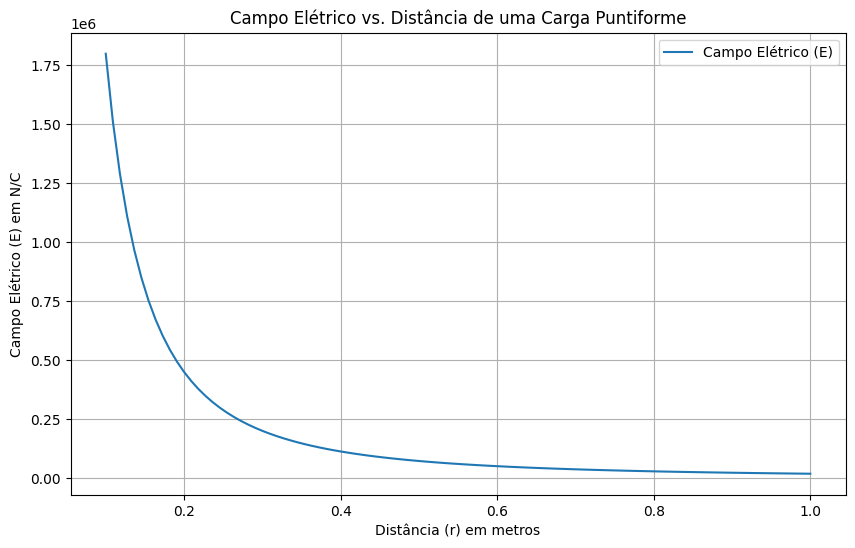

In [37]:
 import matplotlib.pyplot as plt
 import numpy as np


 # Constantes
 k = 8.99e9  # N.m^2/C^2
 q = 2e-6  # C


 # Distâncias
 r = np.linspace(0.1, 1, 100)  # de 0.1m a 1m


 # Calcula o campo elétrico
 E = k * q / (r**2)


 # Cria o gráfico
 plt.figure(figsize=(10, 6))
 plt.plot(r, E, label='Campo Elétrico (E)')
 plt.xlabel('Distância (r) em metros')
 plt.ylabel('Campo Elétrico (E) em N/C')
 plt.title('Campo Elétrico vs. Distância de uma Carga Puntiforme')
 plt.grid(True)
 plt.legend()
 plt.show()